In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import governing_equations
from unified_model import gridsearch  # <-- The new set of tools we'll be using exist in the `gridsearch` module
from unified_model import optimize
from unified_model.metrics import root_mean_square

from flux_curve_modelling.model import CurveModel

In [42]:
# Mechanical components
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='./data/magnetic-spring/10x10alt.csv',
    magnet_length=10/1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)
magnet_assembly = mechanical_components.MagnetAssembly(
    n_magnet=1,
    l_m=10,
    l_mcd=0,
    dia_magnet=10,
    dia_spacer=10
)
mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,
    damping_coefficient=7.778,
    magnet_length=10/1000
)
damper = mechanical_components.ConstantDamper(0.0433)

# Electrical Components
R_coil = None  # Need to get from `optimize` module
load = electrical_components.SimpleLoad(R=30)
v_rect_drop = 0.1
coupling_model = CouplingModel().set_coupling_constant(4.444)

# Initial flux model
coil_params = {
   'beta': 1361/1000/1000,
    'n_z': 20,
    'n_w': 20,
    'l_th': 2,
    'r_c': 0.143/2,
    'c': 2,
    'm': 1,
    'c_c': 0.059,
    'r_t': 5.5,
}


curve_model = CurveModel.load('./flux_curve_model.model')

# TODO: Might not be needed
flux_model, dflux_model = optimize.get_new_flux_and_dflux_model(curve_model, coil_params)

# Build our first "template" factory
unified_model_factory = gridsearch.UnifiedModelFactory(
    damper=damper,
    magnet_assembly=magnet_assembly,
    mechanical_spring=mech_spring,
    magnetic_spring=magnetic_spring,
    coil_resistance=None,
    rectification_drop=v_rect_drop,
    load_model=load,
    flux_model=None,
    dflux_model=None,
    coupling_model=coupling_model,
    governing_equations=governing_equations.unified_ode,
    model_id=0,
)

# Choose our input excitations, in the case just one (for now)
acc_input = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='./data/2019-05-23_D/A/log_02_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

# Try evolve it
coil_params['n_z'] = 20
coil_params['n_w'] = 20

simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                  input_excitations=[acc_input],
                                                  curve_model=curve_model,
                                                  coil_model_params=coil_params)


um = simulation_models[0]

ValueError: l_ccd = 0, but c > 1

In [80]:
from unified_model.electrical_components.flux.model import FluxModelInterp

def find_optimal_spacing(curve_model, coil_model_params):
    coil_model_params['c'] = 2
    coil_model_params['l_ccd'] = 0.1
    flux_interp_model = FluxModelInterp(**coil_model_params)
    z_arr, phi = optimize._get_new_flux_curve(curve_model=curve_model,
                                              n_z=coil_model_params['n_z'],
                                              n_w=coil_model_params['n_w'])
    flux_interp_model.fit(z_arr, phi.flatten())
    return flux_interp_model.flux_model

f = find_optimal_spacing(curve_model, coil_params)

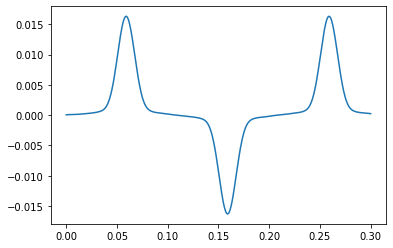

In [84]:
x = np.linspace(0, 0.3, 1000)
phi  = [f.get(x) for x in x]

plt.plot(x, phi)

In [40]:
print(um.electrical_model.coil_resistance)

um.solve(t_start=0,
        t_end=8,
        y0=[0., 0., 0.04, 0., 0.],
        t_max_step=1e-3,
        t_eval=np.arange(0, 8, 2e-3))

31.034796054986785


{'rms': 0.060019973072409756}


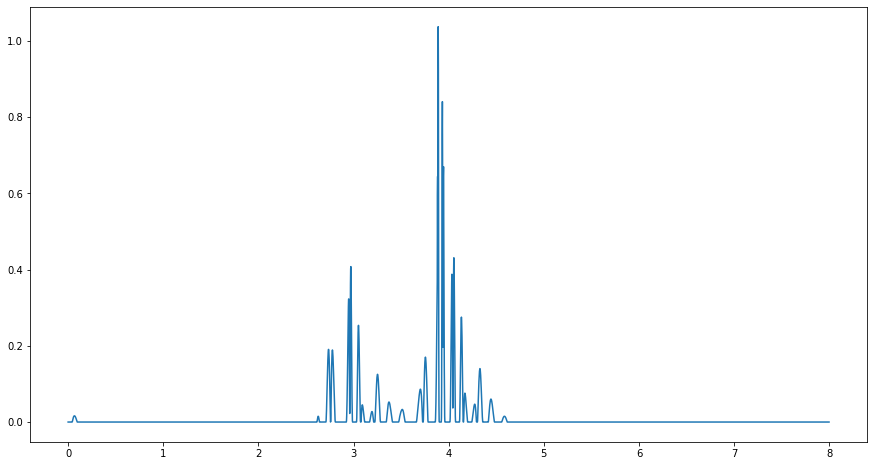

In [41]:
import matplotlib.pyplot as plt

def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

print(um.calculate_metrics('g(t, x5)', {
    'rms': calculate_rms
}))


df = um.get_result(time='t', mag_pos='x3-x1', emf='g(t, x5)') 
plt.figure(figsize=(15, 8))
plt.plot(df['time'], df['emf'])

In [17]:
from typing import List, Dict, Any
import ray

ray.init(ignore_reinit_error=True)

@ray.remote
def sim(unified_model):
    result = unified_model.solve(
        t_start=0,
        t_end=8,
        y0=[0., 0., 0.04, 0., 0.],
        t_max_step=1e-3,
        t_eval=np.arange(0, 8, 1e-3)
    )
    
    results = unified_model.calculate_metrics('g(t, x5)', {
        'rms': calculate_rms
    })
    results['r_coil'] = unified_model.electrical_model.coil_resistance
    
    return results


2020-10-22 09:59:42,998	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.


In [20]:
from itertools import product

n_z_arr = np.arange(5, 120, 10)
n_w_arr = np.arange(5, 60, 10) 

nz_nw_product = np.array(list(product(n_z_arr, n_w_arr)))
obj_ids = []
for n_z, n_w in nz_nw_product:
    coil_params['n_z'] = n_z
    coil_params['n_w'] = n_w

    simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                      input_excitations=[acc_input],
                                                      curve_model=curve_model,
                                                      coil_model_params=coil_params)


    um = simulation_models[0]
    obj_ids.append(sim.remote(um))

In [21]:
ready = []
timeout=5
while len(ready) < len(obj_ids):
    ready, waiting = ray.wait(obj_ids, num_returns=len(obj_ids), timeout=timeout)
    print(len(ready), len(waiting))

18 54
27 45
35 37
44 28
52 20
61 11
70 2
72 0


In [22]:
results = ray.get(ready)
rms = [r['rms'] for r in results]

df = pd.DataFrame({
    'n_z': nz_nw_product[:, 0],
    'n_w': nz_nw_product[:, 1],
    'rms': [r['rms'] for r in results],
    'r_coil': [r['r_coil'] for r in results]
})

df.head()

,n_z,n_w,rms,r_coil
0,5,5,0.006688,1.710390
1,5,15,0.012932,5.589739
2,5,25,0.028469,10.080515
3,5,35,0.036543,15.182717
4,5,45,0.039558,20.896345


In [27]:
df.sort_values(by='rms', ascending=False)

,n_z,n_w,rms,r_coil
55,95,15,0.105332,106.205049
61,105,15,0.105211,117.384528
49,85,15,0.104431,95.025570
67,115,15,0.104301,128.564007
50,85,25,0.104029,171.368757
...,...,...,...,...
18,35,5,0.020465,11.972730
1,5,15,0.012932,5.589739
12,25,5,0.010977,8.551950
6,15,5,0.007578,5.131170


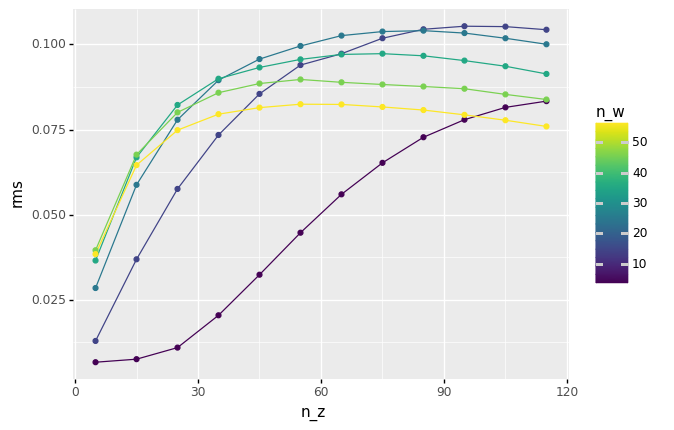

<ggplot: (8752181165305)>

In [38]:
p = ggplot(aes(x='n_z', y='rms', color='n_w', group='n_w'), df)
p + geom_line() + geom_point()

In [23]:
from plotnine import *

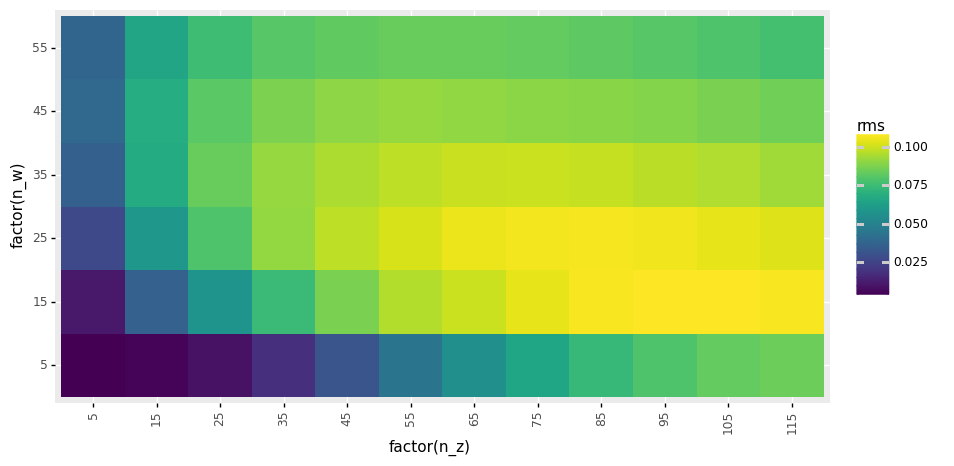

<ggplot: (8751830153001)>

In [24]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='rms'), df)
p + geom_tile() + coord_equal() + theme(axis_text_x=element_text(angle=90), figure_size=(10, 5))

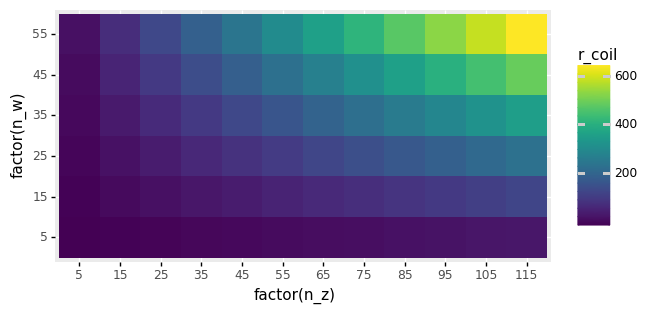

<ggplot: (8751830106325)>

In [25]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='r_coil'), df)
p + geom_tile() + coord_equal()

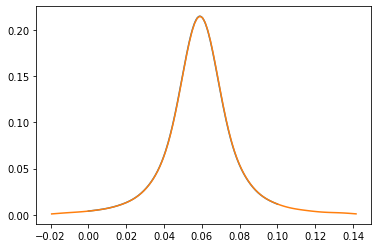

In [234]:
# Double check we get the same flux curves
coil_params['n_z'] = 55
coil_params['n_w'] = 145

simulation_models = optimize.evolve_simulation_set(
    unified_model_factory=unified_model_factory,
    input_excitations=[acc_input],
    curve_model=curve_model,
    coil_model_params=coil_params)

um = simulation_models[0]


xs = np.linspace(0, 0.1, 1000)
phi_from_model = [um.electrical_model.flux_model.get(x) for x in xs]
plt.plot(xs, phi_from_model)

xs, phi = curve_model.predict_curve([[coil_params['n_z'], coil_params['n_w']]])
plt.plot(xs + 0.059, phi.flatten())

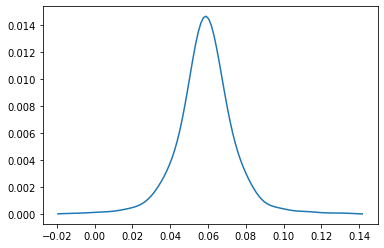

In [188]:
xs, phi = curve_model.predict_curve([[5, 95]])
plt.plot(xs + 0.059, phi.flatten())

# xs, phi = curve_model.predict_curve([[15, 65]])
# plt.plot(xs, phi.flatten())